# End-to-End Diabetes Machine Learning 

# Pipeline I

**Uçtan Uca Diyabet Makine Öğrenimi İş Hattı I**

## 1. Exploratory Data Analysis
## 2. Data Preprocessing & Feature Engineering
## 3. Base Models
## 4. Automated Hyperparameter Optimization
## 5. Stacking & Ensemble Learning
## 6. Prediction for a New Observation
## 7. Pipeline Main Function


In [1]:
# Gerekli kütüphanelerin yüklenmesi
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler


In [2]:
# Gerekli kütüphaneleri yükleyim

#!pip install catboost
#!pip install lightgbm
#!pip install xgboost

In [3]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
# DataFrame görüntüleme seçeneklerinin ayarlanması
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)


# 1. Exploratory Data Analysis

In [5]:
def check_df(dataframe, head=5):
    """
    Veri çerçevesinin şekli, türleri, başı ve sonu, eksik değer sayıları, çeyreklikler gibi temel bilgileri gösteren fonksiyon.

    Parameters:
    dataframe (pd.DataFrame): İncelenmek istenen veri çerçevesi.
    head (int): Baş ve son kısımların kaç satır gösterileceğini belirten parametre. Varsayılan değer 5.

    Returns:
    None
    """
    # Veri çerçevesinin şekli (satır ve sütun sayısı)
    print("##################### Shape #####################")
    print(dataframe.shape)

    # Veri çerçevesindeki değişkenlerin türleri
    print("##################### Types #####################")
    print(dataframe.dtypes)

    # Veri çerçevesinin başı (ilk `head` satır)
    print("##################### Head #####################")
    print(dataframe.head(head))

    # Veri çerçevesinin sonu (son `head` satır)
    print("##################### Tail #####################")
    print(dataframe.tail(head))

    # Eksik değer sayıları
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    # Çeyreklikler
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1], interpolation='nearest').T)

In [6]:
def cat_summary(dataframe, col_name, plot=False):
    """
    Bu fonksiyon, bir veri çerçevesindeki kategorik bir değişkenin sınıf frekanslarına ve oranlarına dair bilgileri gösterir.

    Parameters:
    - dataframe: İncelenmek istenen veri çerçevesi.
    - col_name: Frekansları ve oranları hesaplanacak kategorik değişkenin ismi.
    - plot: Varsayılan olarak False değerine sahip bu parametre, kategorik değişkenin frekanslarını gösteren bir çubuk grafiği çizilip çizilmeyeceğini belirler.

    Returns:
    None
    """
    # Kategorik değişkenin sınıf frekanslarını ve oranlarını hesapla
    class_counts = dataframe[col_name].value_counts()
    class_ratios = 100 * class_counts / len(dataframe)

    # Hesaplanan bilgileri bir veri çerçevesine dönüştür
    summary_df = pd.DataFrame({col_name: class_counts, "Ratio": class_ratios})

    # Elde edilen bilgileri ekrana yazdır
    print(summary_df)
    print("##########################################")

    # Eğer plot parametresi True olarak belirlenmişse, çubuk grafiği çiz
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)


In [7]:
def num_summary(dataframe, numerical_col, plot=False):
    """
    Bu fonksiyon, bir veri çerçevesindeki sayısal bir değişkenin temel istatistiklerini ve istenirse bir histogramını gösterir.

    Parameters:
    - dataframe: İncelenmek istenen veri çerçevesi.
    - numerical_col: Temel istatistikleri ve histogramı çizilecek sayısal değişkenin ismi.
    - plot: Varsayılan olarak False değerine sahip bu parametre, sayısal değişkenin histogramını çizilip çizilmeyeceğini belirler.

    Returns:
    None
    """
    # Temel istatistikleri hesapla
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    descriptive_stats = dataframe[numerical_col].describe(quantiles).T

    # Hesaplanan istatistikleri ekrana yazdır
    print(descriptive_stats)

    # Eğer plot parametresi True olarak belirlenmişse, sayısal değişkenin histogramını çiz
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


Bu fonksiyon, bir veri çerçevesindeki **kategorik bir hedef** değişkenle **sayısal** bir değişkenin **ilişkisini özetleyen istatistikler** üretir. Fonksiyon, gruplama işlemini gerçekleştirir, her kategori için sayısal değişkenin ortalamasını hesaplar ve sonuçları ekrana yazdırır.

In [8]:
def target_summary_with_num(dataframe, target, numerical_col):
    """
    Bu fonksiyon, kategorik bir hedef değişkenle sayısal bir değişkenin ilişkisini gösteren özet istatistikler üretir.

    Parameters:
    - dataframe: İncelenmek istenen veri çerçevesi.
    - target: Hedef değişkenin ismi.
    - numerical_col: İlişkiyi göstermek istediğimiz sayısal değişkenin ismi.

    Returns:
    None
    """
    # Veri çerçevesini hedef değişken üzerinden grupla, sayısal değişkenin ortalamasını hesapla ve ekrana yazdır
    summary = dataframe.groupby(target).agg({numerical_col: "mean"})
    print(summary, end="\n\n\n")

Bu fonksiyon, bir veri çerçevesindeki **sayısal bir hedef** değişkenle **kategorik** bir değişkenin **ilişkisini özetleyen istatistikler** üretir. Fonksiyon, gruplama işlemini gerçekleştirir, her kategori için hedef değişkenin ortalamasını hesaplar ve sonuçları ekrana yazdırır.

In [9]:
def target_summary_with_cat(dataframe, target, categorical_col):
    """
    Bu fonksiyon, sayısal bir hedef değişkenle kategorik bir değişkenin ilişkisini gösteren özet istatistikler üretir.

    Parameters:
    - dataframe: İncelenmek istenen veri çerçevesi.
    - target: Sayısal hedef değişkenin ismi.
    - categorical_col: İlişkiyi göstermek istediğimiz kategorik değişkenin ismi.

    Returns:
    None
    """
    # Veri çerçevesini kategorik değişken üzerinden grupla, hedef değişkenin ortalamasını hesapla ve ekrana yazdır
    summary = pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()})
    print(summary, end="\n\n\n")


Bu fonksiyon, belirli sütunlardan oluşan bir veri çerçevesindeki **korelasyon matrisini** hesaplar ve görselleştirir. Korelasyon matrisini göstermek için seaborn kütüphanesinin heatmap fonksiyonunu kullanır. Fonksiyon, belirtilen sütunları içeren bir korelasyon matrisi oluşturur ve bu matrisi **ısı haritası** olarak görselleştirir.

In [10]:
def correlation_matrix(df, cols):
    """
    Bu fonksiyon, belirli sütunlardan oluşan bir veri çerçevesindeki korelasyon matrisini görselleştirir.

    Parameters:
    - df: Veri çerçevesi.
    - cols: Korelasyon matrisini görselleştirmek istediğiniz sütunların listesi.

    Returns:
    None
    """
    # Korelasyon matrisini hesapla
    correlation_matrix = df[cols].corr()

    # Görselleştirme
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)


Bu fonksiyon, bir veri çerçevesindeki **değişkenlerin türlerine göre** gruplandırılmasını sağlar. Veri çerçevesindeki değişkenleri;

- Kategorik 
- Numerik 
- Kategorik görünümlü kardinal (Sayısal olsada sınıf sayısı az olduğu için kategorik listesine atılan değişkenler.)

olarak **üç farklı grup altında toplar**. Fonksiyonun dönüş değeri olarak bu üç grup içindeki değişken isimlerini içeren üç liste verir. Fonksiyonun çağrılması örnekleri de açıklamalarda verilmiştir.

In [11]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    
    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols, num_cols, cat_but_car

Bu kod bloğu, bir veri çerçevesinin temel özelliklerini kontrol etmek için kullanılır.

In [12]:
df = pd.read_csv("datasets/diabetes.csv")  # Diabetes veri setini yükleme

check_df(df)  # Veri setinin temel özelliklerini kontrol etme

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

Fonksiyonu çağırırken **cat_th=5** olarak ayarladık. Bu sayede bir sayısal değişkende 5 den az sınıf varsa bunu kategorik değişken olarak görecek. 5 den fazla varsa sayısal olarak görecek. Kardinal için ise bu değeri 20 olarak ayarladık. Herhangi bir bilgi girilmese fonksiyon içerisindeki varsayılan değeri kullanır. 

In [13]:
# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

print("Kategorik Değişkenler:")
print(cat_cols)
print("\nNumerik Değişkenler:")
print(num_cols)
print("\nKategorik Görünümlü Kardinal Değişkenler:")
print(cat_but_car)

Kategorik Değişkenler:
['Outcome']

Numerik Değişkenler:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Kategorik Görünümlü Kardinal Değişkenler:
[]


Görüldüğü üzere tek kategorik değişken bağımlı (hedef) değişkenimiz.

In [14]:
# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df, col)

         Outcome      Ratio
Outcome                    
0            500  65.104167
1            268  34.895833
##########################################


In [15]:
# Sayısal değişkenlerin incelenmesi
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


Tabloyu incelediğimizde **Insuline** değerinde anormallik var gibi gözüküyor. Çünkü ortalama değer 79 ve 3. çeyrek (%75) 127 iken max değer 846 gelmiş. 

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


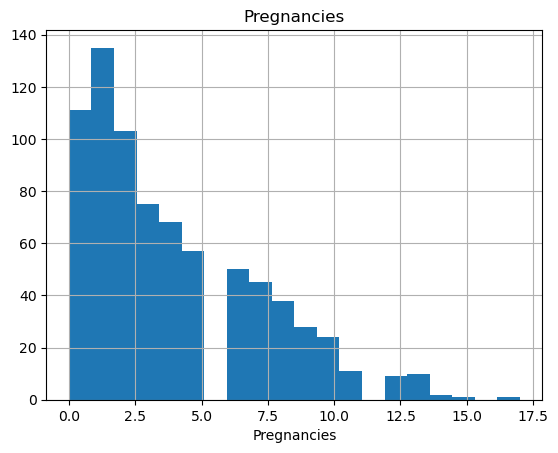

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


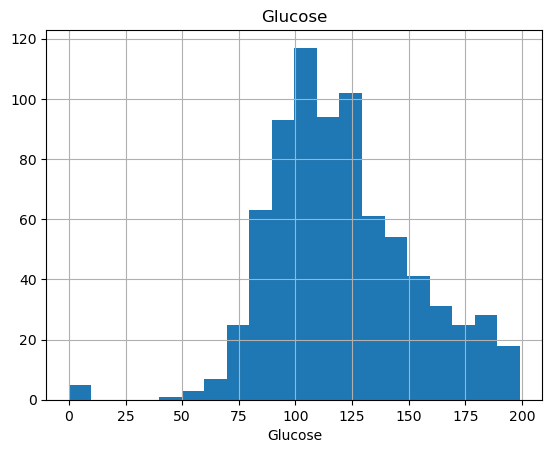

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


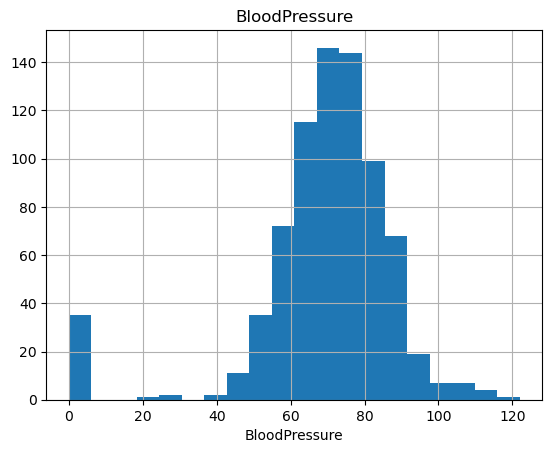

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


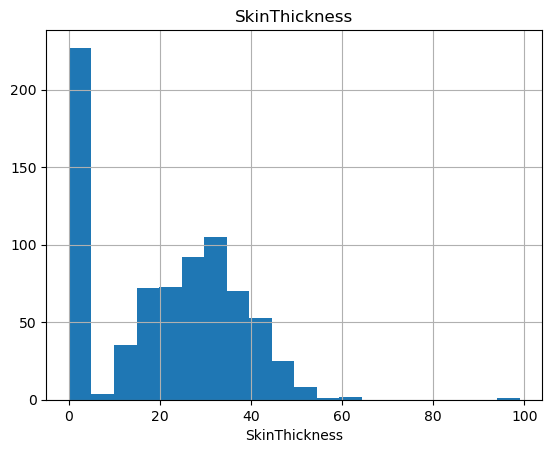

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


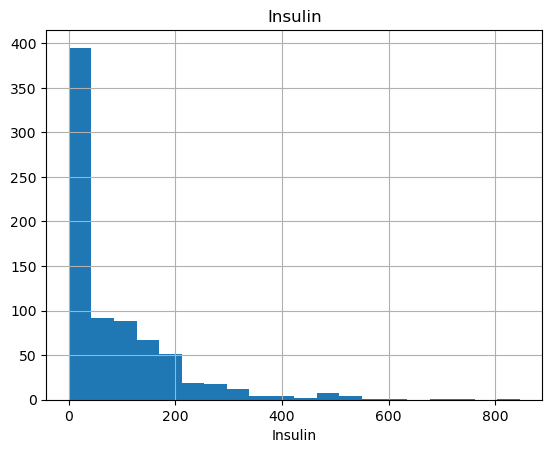

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


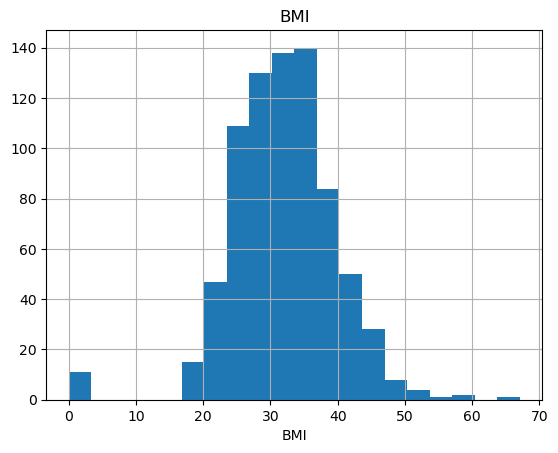

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


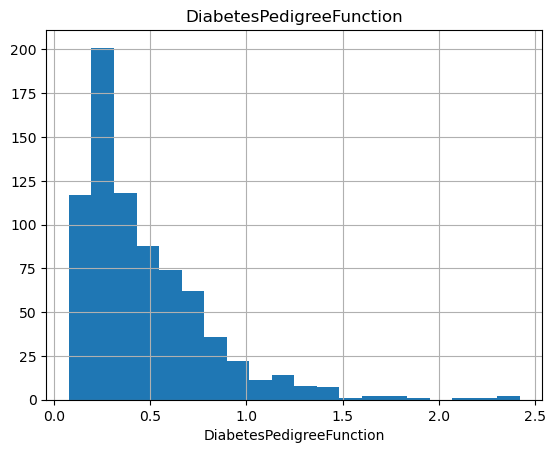

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


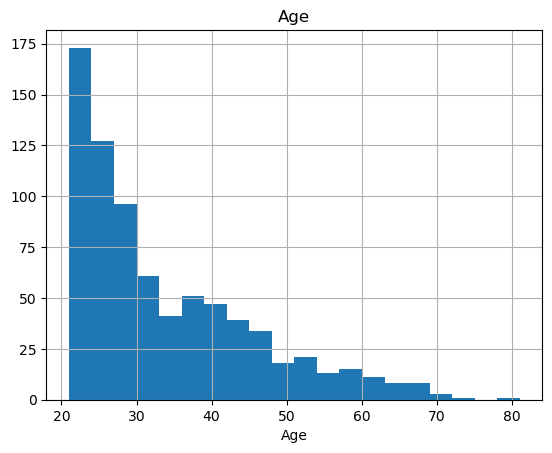

In [16]:
# Sayısal değişkenlerin grafiği
for col in num_cols:
    num_summary(df, col, plot=True)

Grafikte genel veri dağılımına aykırı gözüken değerleri inceleyebilirsiniz.

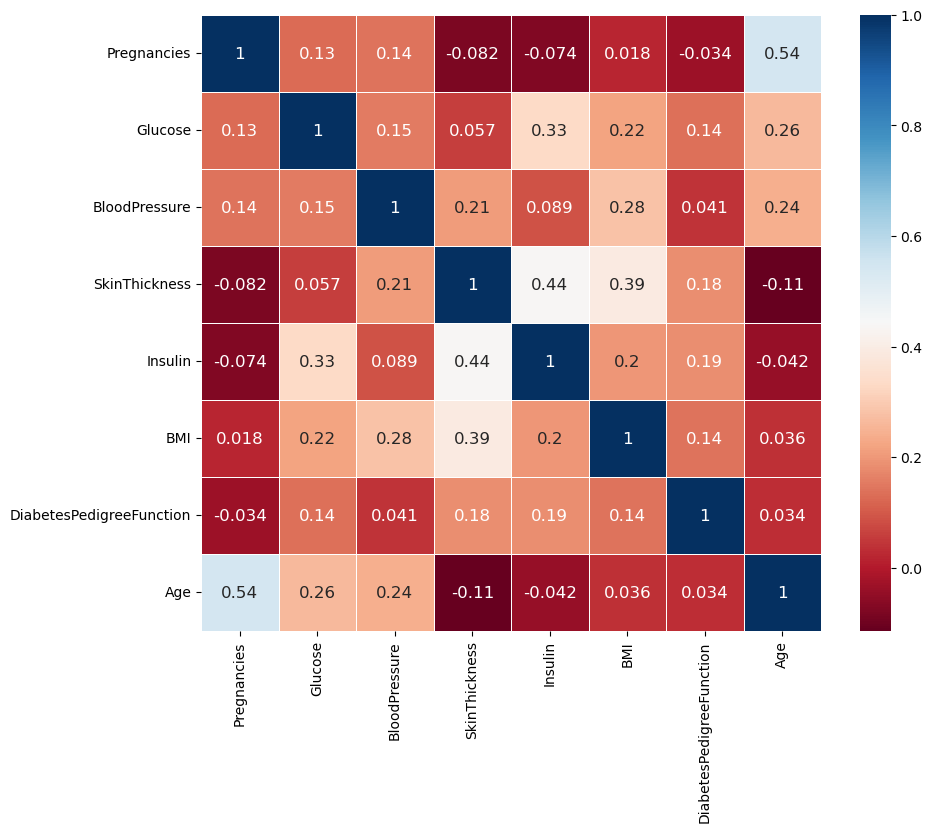

In [17]:
# Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df, num_cols)

Matrisi inecelersek hamilelik ile yas arasındaki 0.54'luk pozitif yönlü orta şiddetli bir korelasyon mevcut. Yani yaş arttıkça hamilelik oranı artmaktadır.

Aynı şekilde Insulin ile SkinThickness arasında 0.44 oranında pozitif korelasyon mevcut.

In [18]:
# Target ile sayısal değişkenlerin incelemesi
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)


         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




Yukarıda bağımlı değişkene göre, bağımsı değişkenlerin ortalaması görülmektedir. Yani diabet hastası (1) olanların yaş ortalaması 37 iken diabet hastası olmayanların (0) yaş ortalaması 31 miş. Bu şekilde bilgi edinebiliriz.

# 2. Data Preprocessing & Feature Engineering

Bu fonksiyon, veri setindeki sayısal değişkenler için aykırı değer sınırlarını hesaplamak için kullanılır.

In [19]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    # col_name isimli sayısal değişkenin aykırı değer sınırlarını belirleme

    # quartile1 ve quartile3, col_name değişkeninin belirtilen quantile'larını hesapla
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)

    # interquantile_range, col_name değişkeninin interquantile range'ini hesapla
    interquantile_range = quartile3 - quartile1

    # up_limit ve low_limit, belirtilen formülle aykırı değer sınırlarını hesapla
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range

    # low_limit ve up_limit değerlerini döndür
    return low_limit, up_limit

Bu fonksiyon, belirli bir sayısal değişkenin aykırı değerlerini, önceden belirlenen alt ve üst sınırlarla değiştirmek için kullanılır. 

In [20]:
def replace_with_thresholds(dataframe, variable):
    # dataframe içindeki belirli bir sayısal değişkenin aykırı değerlerini alt ve üst sınırlarla değiştirme

    # alt_limit ve up_limit, belirli değişken için önceden hesaplanmış aykırı değer sınırlarını al
    low_limit, up_limit = outlier_thresholds(dataframe, variable)

    # dataframe içinde, belirli değişkenin altındaki değerleri low_limit ile değiştir
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit

    # dataframe içinde, belirli değişkenin üstündeki değerleri up_limit ile değiştir
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

Bu fonksiyon, belirli bir sayısal değişkenin altında veya üstünde aykırı değer içerip içermediğini kontrol eder. Eğer aykırı değer bulunursa True, bulunmazsa False döndürür.

In [21]:
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    # belirli bir sayısal değişkenin aykırı değer içerip içermediğini kontrol etme

    # outlier_thresholds fonksiyonunu kullanarak alt ve üst sınırları al
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)

    # dataframe içinde, belirli değişkenin altındaki veya üstündeki değerler var mı kontrol et
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        # Eğer aykırı değer varsa True döndür
        return True
    else:
        # Eğer aykırı değer yoksa False döndür
        return False

Bu fonksiyon, belirtilen kategorik değişkenleri one-hot encoding ile dönüştürür ve dönüştürülmüş veriyi geri döndürür.

In [22]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    # Kategorik değişkenleri one-hot encoding ile dönüştürme

    # get_dummies fonksiyonunu kullanarak one-hot encoding yap
    # drop_first parametresi, ilk kategoriyi bırakma veya bırakmama seçeneğini kontrol eder
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)

    # dönüştürülmüş veriyi döndür
    return dataframe

In [23]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
# Değişken isimleri büyütmek
df.columns = [col.upper() for col in df.columns]

Bu kod parçası, "GLUCOSE" değişkenini bölerek yeni bir kategorik değişken oluşturmayı amaçlar. Burada amaç glucose değeri 0-139 arasında olanlara = normal, 140-200 arasında olanlara prediabetes (ön diabet) gibi bir isimlendirme yapılır.

-1' den başlama sebebi sıfırı da dahil etmektir. Eğer bu şekilde yapmazsak değeri NA değerler oluşabilir.

In [25]:
# 'GLUCOSE' değişkenini belirli aralıklara bölerek yeni bir kategorik değişken oluşturma
# Bins: -1'den 139'a kadar olanlar 'normal', 139'dan 200'e kadar olanlar 'prediabetes' olarak etiketlenir
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])


In [26]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes
1,1,85,66,29,0,26.6,0.351,31,0,normal
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes
3,1,89,66,23,94,28.1,0.167,21,0,normal
4,0,137,40,35,168,43.1,2.288,33,1,normal


Artık elimizde iki sınıflı yeni bir kategorik değişken var. Aynı işlem diğer değişkenler için de yapılabilir.


Bu kod parçası, "AGE" değişkenini belirli aralıklara göre böler ve bu aralıklara göre yeni bir kategorik değişken olan "NEW_AGE_CAT" oluşturur. 

- Yaşı 35 den küçük olanlar "young"

- 35'e eşit ve büyük olanlar "middleage"

- 55'den büyük olanlar ise "old"

In [27]:
# 'AGE' değişkenini belirli aralıklara göre bölen ve yeni bir kategorik değişken oluşturan kod
# Yaş 35'ten küçükse 'young', 35 ile 55 arasındaysa 'middleage', 55'ten büyükse 'old' olarak etiketlenir
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

Bu kod parçası, "BMI" (Vücut Kitle İndeksi) değişkenini belirli aralıklara göre bölen ve bu aralıklara göre yeni bir kategorik değişken olan "NEW_BMI_RANGE" oluşturan bir kod parçasıdır.

In [28]:
# 'BMI' değişkenini belirli aralıklara göre bölen ve yeni bir kategorik değişken oluşturan kod
# BMI'nın değerine göre, 'underweight', 'healty', 'overweight' ve 'obese' kategorilerine ayrılır
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healty", "overweight", "obese"])


Bu kod parçası, "BLOODPRESSURE" (Kan Basıncı) değişkenini belirli aralıklara göre bölen ve bu aralıklara göre yeni bir kategorik değişken olan "NEW_BLOODPRESSURE" oluşturan bir kod parçasıdır.

In [29]:
# 'BLOODPRESSURE' değişkenini belirli aralıklara göre bölen ve yeni bir kategorik değişken oluşturan kod
# Kan basıncının değerine göre, 'normal', 'hs1' ve 'hs2' kategorilerine ayrılır
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])

In [30]:
check_df(df)

##################### Shape #####################
(768, 13)
##################### Types #####################
PREGNANCIES                    int64
GLUCOSE                        int64
BLOODPRESSURE                  int64
SKINTHICKNESS                  int64
INSULIN                        int64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                            int64
OUTCOME                        int64
NEW_GLUCOSE_CAT             category
NEW_AGE_CAT                   object
NEW_BMI_RANGE               category
NEW_BLOODPRESSURE           category
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME NEW_GLUCOSE_CAT NEW_AGE_CAT NEW_BMI_RANGE NEW_BLOODPRESSURE
0            6      148             72             35        0  33.6                     0.627   50        1     prediabetes   middleage         obese            normal
1       

Bu kod, `df` veri çerçevesindeki değişkenleri ayırarak üç farklı değişken listesi elde etmenizi sağlar. Bu listeler şunlardır:

- **`cat_cols`**: Kategorik değişkenlerin isimlerini içeren liste.
- **`num_cols`**: Sayısal değişkenlerin isimlerini içeren liste.
- **`cat_but_car`**: Kategorik fakat kardinal değişkenlerin isimlerini içeren liste.

Bu listeleri daha sonra çeşitli analiz ve işlemlerde kullanabilirsiniz.

In [31]:
# Kategorik, numerik ve kategorik fakat kardinal değişkenleri belirleme
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

In [32]:
# Kategorik değişkenlerin özetini görüntüleme
for col in cat_cols:
    cat_summary(df, col)

             NEW_AGE_CAT      Ratio
NEW_AGE_CAT                        
young                488  63.541667
middleage            230  29.947917
old                   50   6.510417
##########################################
         OUTCOME      Ratio
OUTCOME                    
0            500  65.104167
1            268  34.895833
##########################################
                 NEW_GLUCOSE_CAT      Ratio
NEW_GLUCOSE_CAT                            
normal                       571  74.348958
prediabetes                  197  25.651042
##########################################
               NEW_BMI_RANGE      Ratio
NEW_BMI_RANGE                          
obese                    472  61.458333
overweight               179  23.307292
healty                   102  13.281250
underweight               15   1.953125
##########################################
                   NEW_BLOODPRESSURE      Ratio
NEW_BLOODPRESSURE                              
normal                  

Bağımlı değişkenimiz ile yeni oluşturulan değişkenler arasındaki ilişkiyi inceleyelim;

In [33]:
# Kategorik değişkenlerin target değişkenle ilişkisini inceleme
for col in cat_cols:
    target_summary_with_cat(df, "OUTCOME", col)

             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healty            0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333




C:\Users\Administrator\AppData\Local\Temp\ipykernel_18572\1826451413.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()})
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18572\1826451413.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()})
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18572\1826451413.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pand

In [34]:
# "OUTCOME" içeren kategorik değişkenlerden çıkarma
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [35]:
# One-Hot Encoding işlemi
df = one_hot_encoder(df, cat_cols, drop_first=True)

# Veri setini kontrol etme
check_df(df)

##################### Shape #####################
(768, 17)
##################### Types #####################
PREGNANCIES                      int64
GLUCOSE                          int64
BLOODPRESSURE                    int64
SKINTHICKNESS                    int64
INSULIN                          int64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                              int64
OUTCOME                          int64
NEW_AGE_CAT_old                   bool
NEW_AGE_CAT_young                 bool
NEW_GLUCOSE_CAT_prediabetes       bool
NEW_BMI_RANGE_healty              bool
NEW_BMI_RANGE_overweight          bool
NEW_BMI_RANGE_obese               bool
NEW_BLOODPRESSURE_hs1             bool
NEW_BLOODPRESSURE_hs2             bool
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  NEW_AGE_CAT_old  NEW_AGE_CAT_young  NEW_GLUCOSE_CAT_pr

In [36]:
# Sütun isimlerini büyük harfe çevirme
df.columns = [col.upper() for col in df.columns]

In [37]:
# Değişken türlerini belirleme
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

# "OUTCOME" kelimesini içeren kategorik değişkenleri filtreleme
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [38]:
# Sayısal değişkenlerin aykırı değerlerini kontrol etme
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


**Insulin** değişkeni **aykırı** olarak gözüküyor.


In [39]:
# "INSULIN" değişkeninin aykırı değerlerini düzenleme
replace_with_thresholds(df, "INSULIN")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18572\830357479.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-190.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [40]:
# Standartlaştırma
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

# Bağımlı ve bağımsız değişkenleri ayarlama
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

In [41]:
check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                   bool
NEW_AGE_CAT_YOUNG                 bool
NEW_GLUCOSE_CAT_PREDIABETES       bool
NEW_BMI_RANGE_HEALTY              bool
NEW_BMI_RANGE_OVERWEIGHT          bool
NEW_BMI_RANGE_OBESE               bool
NEW_BLOODPRESSURE_HS1             bool
NEW_BLOODPRESSURE_HS2             bool
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTY  NEW_

Bu fonksiyon, veri setinde yer alan "DIABETES" adlı veri setini hazırlamak için kullanılır. Veri setindeki değişkenlerin isimlerini büyük harfe çevirir, yeni özellikler ekler, kategorik değişkenleri one-hot encode eder, aykırı değerleri düzeltir ve sayısal değişkenleri standartlaştırır. Son olarak, bağımlı değişkeni ("OUTCOME") ve bağımsız değişkenleri ayırarak X ve y olarak döndürür.

Fonksiyonun adı **`diabetes_data_prep`**, ve parametre olarak bir dataframe (**`dataframe`**) alır. Fonksiyonun döndürdüğü değerler X ve y'dir. Bu değerler, veri setinin hazırlanmış hali ile modelleme aşamasında kullanılmak üzere elde edilmiş olacaktır.

In [42]:
def diabetes_data_prep(dataframe):
    # Değişken isimlerini büyük harfe çevirme
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose için yeni kategorik değişken oluşturma
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age için yeni kategorik değişken oluşturma
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI için yeni kategorik değişken oluşturma
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure için yeni kategorik değişken oluşturma
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    # Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini al
    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    # Kategorik değişkenleri one-hot encode et
    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]
    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    # One-hot encode sonrası değişken isimlerini büyük harfe çevir
    df.columns = [col.upper() for col in df.columns]

    # Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini al
    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    # Aykırı değerleri düzeltme
    replace_with_thresholds(df, "INSULIN")

    # Sayısal değişkenleri standartlaştırma
    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    # Bağımlı ve bağımsız değişkenleri ayırma
    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

Veri setimizi baştan okuttuk ve artık tek fonksiyon (**diabetes_data_prep**) ile tüm işlemeleri gerçekleştireceğiz.

In [43]:
# Diabetes veri setini okuma
df = pd.read_csv("datasets/diabetes.csv")

# Veri setini kontrol etme
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [44]:
# Veri setini hazırlama işlemi
X, y = diabetes_data_prep(df)

# Hazırlanan veri setini kontrol etme
check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                   bool
NEW_AGE_CAT_YOUNG                 bool
NEW_GLUCOSE_CAT_PREDIABETES       bool
NEW_BMI_RANGE_HEALTY              bool
NEW_BMI_RANGE_OVERWEIGHT          bool
NEW_BMI_RANGE_OBESE               bool
NEW_BLOODPRESSURE_HS1             bool
NEW_BLOODPRESSURE_HS2             bool
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTY  NEW_

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18572\830357479.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-190.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


# 3. Base Models

In [45]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

Bu kod, base_models fonksiyonu aracılığıyla farklı sınıflandırma modellerinin performansını ölçer. Ayrıca, accuracy metriği kullanılarak değerlendirme yapılmıştır. 

In [46]:
def base_models(X, y, scoring="roc_auc"):
    """
    Verilen X ve y veri seti üzerinde temel sınıflandırma modellerini kullanarak performanslarını değerlendirir.

    Parameters:
    - X: Bağımsız değişkenler
    - y: Bağımlı değişken
    - scoring: Değerlendirme metriği (varsayılan olarak "roc_auc" kullanılmıştır)

    Returns:
    - None
    """
    print("Base Models....")

    # Kullanılacak sınıflandırıcıları tanımlama
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier(verbose=-1)),
                    ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    # Her bir sınıflandırıcı için çapraz doğrulama yapma ve sonuçları yazdırma
    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

# Veri setini hazırlama
X, y = diabetes_data_prep(df)

# Temel modelleri değerlendirme
# Bu kısımda hangi başarı skoruna bakmak istiyorsanız onu yazın.
# Scoring belirtmezseniz default değer olan AUC ROC değerini gösterir.

# base_models(X, y)
# base_models(X, y, scoring="f1")

base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7604 (LR) 


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18572\830357479.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-190.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


accuracy: 0.7617 (KNN) 
accuracy: 0.7656 (SVC) 
accuracy: 0.6901 (CART) 
accuracy: 0.7695 (RF) 
accuracy: 0.7578 (Adaboost) 
accuracy: 0.7539 (GBM) 
accuracy: 0.7526 (XGBoost) 
accuracy: 0.7383 (LightGBM) 
accuracy: 0.7591 (CatBoost) 


Accuracy değerlerine bakacak olursak en başarılı model **RF>SVC>KNN...** gibi gözüküyor. Fakat değerler birbirine çok yakın. Şimdi ise hiperparametre optimizasyonu yaparak yeniden değerlendirelim.

# 4. Automated Hyperparameter Optimization

Bu kod, sınıflandırıcıların hiperparametre optimizasyonunu gerçekleştirmek için kullanılan bir fonksiyon içerir.

Her bir sınıflandırıcı için hiperparametre araması yapılacak parametre grid'lerini içerir. Bu grid'ler, GridSearchCV veya RandomizedSearchCV gibi fonksiyonlarda kullanılarak en iyi hiperparametre setini bulmak için kullanılabilir.Çapraz doğrulama skorları, optimizasyon öncesi ve sonrası olarak ekrana yazdırılır.

In [47]:
# KNN için parametre grid
knn_params = {"n_neighbors": range(2, 50)}

# Decision Tree (CART) için parametre grid
cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

# Random Forest için parametre grid
rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

# XGBoost için parametre grid
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

# LightGBM için parametre grid
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

# Sınıflandırıcılar ve ilgili parametre grid'leri
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(verbose=-1), lightgbm_params)]

def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    """
    Verilen sınıflandırıcı modelleri için hiperparametre optimizasyonu gerçekleştirir.

    Parameters
    ----------
    X : pandas.DataFrame
        Bağımsız değişkenlerin bulunduğu veri seti.
    y : pandas.Series
        Bağımlı değişken.
    cv : int, optional
        Çapraz doğrulama kat sayısı. Varsayılan değer 3.
    scoring : str, optional
        Model performansını değerlendirmek için kullanılacak metrik. Varsayılan değer "roc_auc".

    Returns
    -------
    best_models : dict
        Hiperparametre optimizasyonu sonucu bulunan en iyi modellerin sözlüğü.

    """
    print("Hyperparameter Optimization....")
    # En iyi modelleri tutmak için dizi oluşturduk.
    best_models = {}
    
    # Her bir sınıflandırıcı için hiperparametre optimizasyonu gerçekleştirme
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        
        # Çapraz doğrulama ile modelin performansını değerlendirme (önce)
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        # GridSearchCV kullanarak en iyi hiperparametreleri bulma
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        # Çapraz doğrulama ile modelin performansını değerlendirme (sonra)
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        
        # En iyi modeli ve hiperparametrelerini kaydetme
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    
    return best_models

Artık en iyi modellere ve hiperparametre setlerine erişebiliriz. Bu şekilde, en iyi modelleri kullanarak tahminleme yapabilir ve model performanslarını değerlendirebilirsiniz. 

In [48]:
best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6534
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8289


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-packages

roc_auc (After): 0.8353
RF best params: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 20, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Before): 0.8008
roc_auc (After): 0.8147
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.807
roc_auc (After): 0.8185
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



Hiperparametre optimizasyonu sonrasında en başarılır model **0.8353** ile **RF** gibi gözüküyor.

# 5. Stacking & Ensemble Learning

Bu fonksiyonun ana görevi, VotingClassifier sınıfını kullanarak verilen en iyi modellerin kombinasyonundan bir ensemble modeli oluşturmak ve bu model üzerinde çapraz doğrulama sonuçlarını değerlendirmektir. Oylama tipi 'soft' olarak belirlenmiştir, yani sınıflandırma sonuçlarının ağırlıklı ortalaması kullanılır. Fonksiyon, oluşturulan Voting Classifier'ın çeşitli performans metriklerini ekrana yazdırır ve son olarak bu modeli döndürür.

Bu kodu kullanarak, en iyi modelleri bir araya getirip bir ensemble modeli oluşturabilir ve bu model üzerinde performans değerlendirmesi yapabilirsiniz.

Burada KNN, RF ve LightGBM kullanmayı tercih ettik. Fakat bir önceki aşamada bulduğumuz en başarılı üç yöntem de tercih edilebilirdi.

In [49]:
def voting_classifier(best_models, X, y):
    # Fonksiyon başlığı
    print("Voting Classifier...")

    # Voting Classifier'ın oluşturulması
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    # Voting Classifier üzerinde çapraz doğrulama sonuçlarının hesaplanması
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])

    # Çapraz doğrulama sonuçlarının ekrana yazdırılması
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")

    # Oluşturulan Voting Classifier'ın döndürülmesi
    return voting_clf

Bu modeli kullanarak tahminlerde bulunabilir ve performansını değerlendirebilirsiniz. 

In [50]:
voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
Accuracy: 0.76953125
F1Score: 0.634075880507638
ROC_AUC: 0.836414121803773


# 6. Prediction for a New Observation

Oluşturulan voting classifier ile tahmin yapacağız.

In [51]:
# X.columns ile kullanılabilir özellik isimlerini görüntüleme
X.columns

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'NEW_AGE_CAT_OLD', 'NEW_AGE_CAT_YOUNG', 'NEW_GLUCOSE_CAT_PREDIABETES', 'NEW_BMI_RANGE_HEALTY', 'NEW_BMI_RANGE_OVERWEIGHT', 'NEW_BMI_RANGE_OBESE', 'NEW_BLOODPRESSURE_HS1', 'NEW_BLOODPRESSURE_HS2'], dtype='object')

In [52]:
# Rastgele bir kullanıcı seçme
random_user = X.sample(1, random_state=45)

# Voting Classifier ile tahmin yapma
voting_clf.predict(random_user)

array([1], dtype=int64)

Bu modeli daha sonra da kullanabilmek için kaydediyoruz.

In [53]:
# Modeli diske kaydetme
joblib.dump(voting_clf, "voting_clf2.pkl")

['voting_clf2.pkl']

In [54]:
# Kaydedilen modeli yükleme
new_model = joblib.load("voting_clf2.pkl")

# Yeni model ile tahmin yapma
new_model.predict(random_user)

array([1], dtype=int64)

Böylece oluşturduğumuz voting classifier ile 3 farklı model üzerinden tahmin yaparak bunların ağırlıklı ortalamasına göre tahmin sonucunu görebiliyoruz.